In [1]:
import os
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import json
import time
import random
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import PIL

/usr/lib/python3/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
import re
import math
from math import ceil
import collections
from functools import partial
import torch.optim as optim
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import model_zoo

In [3]:
!nvidia-htop.py

Mon Mar  7 19:42:57 2022
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 455.38       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 20%   23C    P8    11W / 250W |   9827MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 20%   23C    

In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"]="5"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
config = dict(
    train_path = '../../dataset/RetinalDiseaseData/Retinaldata/Training_Set/Training_Set/Training',
    val_path = '../../dataset/RetinalDiseaseData/Retinaldata/Evaluation_Set/Evaluation_Set/Validation',
    test_path = '../../dataset/RetinalDiseaseData/Retinaldata/Test_Set/Test_Set/Test',
    train_csv = '../../dataset/RetinalDiseaseData/Retinaldata/Training_Set/Training_Set/RFMiD_Training_Labels.csv',
    val_csv = '../../dataset/RetinalDiseaseData/Retinaldata/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv',
    test_csv= '../../dataset/RetinalDiseaseData/Retinaldata/Test_Set/Test_Set/RFMiD_Testing_Labels.csv',
    BATCH_SIZE=8,
    IMAGE_HEIGHT= 512,
    IMAGE_WIDTH = 770,
    lr=0.001, 
    EPOCHS = 2,
    device=device,
    SEED = 42,
    pin_memory=True,
    num_workers=2,
    USE_AMP = True,
    channels_last=False,
    saved_path="saved/resnet18.pt",
    best_saved_path = "saved/resnet18_best.pt"
)

In [6]:
random.seed(config['SEED'])
# If you or any of the libraries you are using rely on NumPy, you can seed the global NumPy RNG 
np.random.seed(config['SEED'])
# Prevent RNG for CPU and GPU using torch
torch.manual_seed(config['SEED'])
torch.cuda.manual_seed(config['SEED'])
torch.backends.cudnn.benchmarks = True
torch.backends.cudnn.deterministic = True

torch.backends.cuda.matmul.allow_tf32 = True

# The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
torch.backends.cudnn.allow_tf32 = True

In [7]:
class CustomTraindata():
    def __init__(self):
        self.train_df = pd.read_csv(config['train_csv'])
        self.images = config['train_path']
        self.transformation2 = transforms.ToPILImage()
        self.transformation = transforms.Compose([
            transforms.Resize((config['IMAGE_HEIGHT'],config['IMAGE_WIDTH'])),
            transforms.ToTensor()])
    def __len__(self):
        return len(self.train_df)
    
    def __getitem__(self,idx):
        df_row = self.train_df.iloc[idx,:]
        img_id, disease = df_row['ID'],df_row['Disease_Risk']
        # diesease == 1 (infection) else no infection
        img_name = f'{img_id}.png'
        
        img = Image.open(os.path.join(self.images,img_name)).convert("RGB")
        width,height = img.size
        scaling = width / height
        img = self.transformation(img)
        return (img,disease)
    
class CustomValdata():
    def __init__(self):
        self.val_df = pd.read_csv(config['val_csv'])
        self.images = config['val_path']
        self.transformation2 = transforms.ToPILImage()
        self.transformation = transforms.Compose([
            transforms.Resize((config['IMAGE_HEIGHT'],config['IMAGE_WIDTH'])),
            transforms.ToTensor()])
    def __len__(self):
        return len(self.val_df)
    
    def __getitem__(self,idx):
        df_row = self.val_df.iloc[idx,:]
        img_id, disease = df_row['ID'],df_row['Disease_Risk']
        # diesease == 1 (infection) else no infection
        img_name = f'{img_id}.png'
        
        img = Image.open(os.path.join(self.images,img_name)).convert("RGB")
        width,height = img.size
        scaling = width / height
        img = self.transformation(img)
        return (img,disease)
    
class CustomTestdata():
    def __init__(self):
        self.test_df = pd.read_csv(config['test_csv'])
        self.images = config['test_path']
        self.transformation2 = transforms.ToPILImage()
        self.transformation = transforms.Compose([
            transforms.Resize((config['IMAGE_HEIGHT'],config['IMAGE_WIDTH'])),
            transforms.ToTensor()])
    def __len__(self):
        return len(self.test_df)
    
    def __getitem__(self,idx):
        df_row = self.test_df.iloc[idx,:]
        img_id, disease = df_row['ID'],df_row['Disease_Risk']
        # diesease == 1 (infection) else no infection
        img_name = f'{img_id}.png'
        
        img = Image.open(os.path.join(self.images,img_name)).convert("RGB")
        width,height = img.size
        scaling = width / height
        img = self.transformation(img)
        return (img,disease)
    

In [8]:
train_data, valid_data, test_data = CustomTraindata(), CustomValdata(),CustomTestdata()
train_dl = torch.utils.data.DataLoader(train_data,batch_size=config['BATCH_SIZE'],shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])
valid_dl = torch.utils.data.DataLoader(valid_data,batch_size=config['BATCH_SIZE'],shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])
test_dl = torch.utils.data.DataLoader(test_data,batch_size=config['BATCH_SIZE'],shuffle=True, num_workers = config['num_workers'],
                                          pin_memory = config['pin_memory'])
print(len(train_dl),len(valid_dl))

240 80


tensor([1, 1, 0, 1, 1, 1, 1, 1])
torch.Size([8, 3, 512, 770])


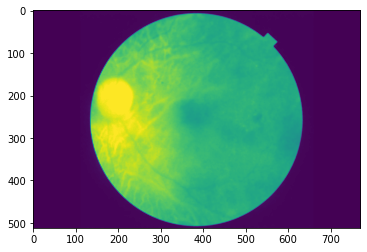

In [9]:
a = iter(test_dl)
b = next(a)
print(b[1])
print(b[0].shape)
plt.imshow(b[0][0][0])

In [17]:
def train_model(model,criterion,optimizer,num_epochs=10):

    history = {}
    history['accuracy'],history['val_accuracy'] = [],[]
    history['loss'], history['val_loss'] = [], []
    batch_ct = 0
    best_acc = 0.3
    example_ct = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        loss = []
        #Training
        model.train()
        run_corrects = 0
        for x,y in train_dl:
            x = x.to(config['device'])
            y = y.to(config['device'])
            
            optimizer.zero_grad()
            #optimizer.zero_grad(set_to_none=True)
            ######################################################################
            
            train_logits = model(x) 
            _, train_preds = torch.max(train_logits, 1)
            train_loss = criterion(train_logits,y)
            run_corrects += torch.sum(train_preds == y.data)
            
            train_loss.backward() # Backpropagation this is where your W_gradient
            loss.append(train_loss.cpu().detach().numpy())

            optimizer.step() # W_new = W_old - LR * W_gradient 
            example_ct += len(x) 
            batch_ct += 1
            
        history['loss'].append(np.mean(np.array(loss)))            
        
        #validation
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total = 0
        # Disable gradient calculation for validation or inference using torch.no_rad()
        with torch.no_grad():
            for x,y in valid_dl:
                x = x.to(config['device'])
                y = y.to(config['device']) #CHW --> #HWC
                valid_logits = model(x)
                _, valid_preds = torch.max(valid_logits, 1)
                valid_loss = criterion(valid_logits,y)
                running_loss += valid_loss.item() * x.size(0)
                running_corrects += torch.sum(valid_preds == y.data)
                total += y.size(0)
            
        epoch_loss = running_loss / len(valid_data)
        epoch_acc = running_corrects.double() / len(valid_data)
        train_acc = run_corrects.double() / len(train_data)
        print("Train Accuracy",train_acc.cpu())
        print("Validation Loss is {}".format(epoch_loss))
        print("Validation Accuracy is {}".format(epoch_acc.cpu()))
        
        history['accuracy'].append(train_acc.cpu())
        history['val_accuracy'].append(epoch_acc.cpu())
        history['val_loss'].append(epoch_loss)
        
        if epoch_acc.cpu()>best_acc:
            print('One of the best validation accuracy found.\n')
            torch.save(model.state_dict(), config['best_saved_path'])
            best_acc = epoch_acc.cpu()
    
    torch.save(model.state_dict(), config['saved_path'])
    return history

# Model

In [12]:
base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)

In [13]:
class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))

In [ ]:
model = EfficientNet(version="b0",num_classes=2)
print(model)

In [15]:
model = model.to(config['device'])
optimizer = optim.Adam(model.parameters(),lr=config['lr'])
criterion = nn.CrossEntropyLoss()

In [ ]:
history = train_model(model, criterion, optimizer, num_epochs=config['EPOCHS'])

In [ ]:
plt.plot(range(config['EPOCHS']),history['accuracy'],label = 'Train Accuracy')
plt.plot(range(config['EPOCHS']),history['val_accuracy'],label = 'Validation Accuracy')
plt.legend()
plt.xlabel('EPOCHS')
plt.ylabel('Accuracy')
plt.title('ACCURACY CURVE')
plt.savefig('crossentropy_acc.png')
plt.show()
plt.clf()

In [ ]:
plt.plot(range(config['EPOCHS']),history['loss'],label = 'Train Loss')
plt.plot(range(config['EPOCHS']),history['val_loss'],label = 'Validation Loss')
plt.legend()
plt.xlabel('EPOCHS')
plt.ylabel('Loss')
plt.title('LOSS CURVE')
plt.savefig('crossentropy_loss.png')
plt.show()